# Prepare data

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA

In [40]:
data=pd.read_csv("C:/Users/xhuli/Documents/GIT_REPOS/DM2Project/trainingDataAfterDataUnderstanding.csv")
data["Weekend"]=data["Weekend"].map(lambda x: 1 if x=="yes" else 0)

In [41]:
data_x=data.drop(columns="Occupancy")

data_y=data["Occupancy"]

from sklearn.preprocessing import StandardScaler

data_x = pd.DataFrame((StandardScaler().fit_transform(data_x.select_dtypes(include=["int64", "float"]))), 
                      columns=(data_x.select_dtypes(include=["int64", "float"])).columns)

print('Initial dataset shape %s' % Counter(data_y))
print('Share of Occupieds %s' % round(data.Occupancy.mean(),2))
print("\n")

Initial dataset shape Counter({0: 6414, 1: 1729})
Share of Occupieds 0.21




# Make imbalance with SMOTE and partition

In [42]:
# from imblearn.datasets import make_imbalance

# data_x, data_y = make_imbalance(data_x, data_y, sampling_strategy={0: 96, 1: 4}, random_state=42)

In [43]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy={0:43225,1:1729}, random_state=42)
data_x, data_y = sm.fit_resample(data_x, data_y)

C:\ProgramData\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:253: UserWarning: After over-sampling, the number of samples (43225) in class 0 will be larger than the number of samples in the majority class (class #0 -> 6414)
  n_samples_majority))


In [44]:
from sklearn.model_selection import train_test_split, cross_val_score 

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=100, stratify=data_y)

In [45]:
print('Partitioned dataset %s' % Counter(y_train))
print('Share of Occupieds %s' % round(y_train.mean(),2))
print("\n")

Partitioned dataset Counter({0: 30257, 1: 1210})
Share of Occupieds 0.04




# PCA with unbalanced data

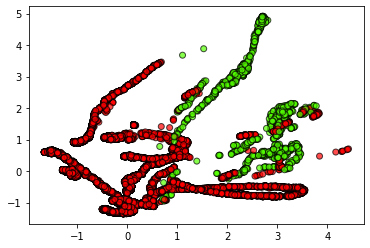

In [46]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

# Decision Tree with Unbalanced data

Accuracy 0.9985912360050418
F1-score [0.99926774 0.98149951]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12968
           1       0.99      0.97      0.98       519

    accuracy                           1.00     13487
   macro avg       1.00      0.99      0.99     13487
weighted avg       1.00      1.00      1.00     13487



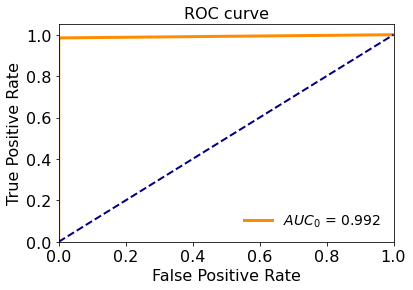

In [57]:
from sklearn.tree import DecisionTreeClassifier 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Undersampling

#### RandomUnderSampler

In [58]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

print('Partitioned and Undersampled dataset %s' % Counter(pd.Series(y_res)))
print('Share of Occupieds %s' % round(y_res.mean(),2))
print("\n")

Partitioned and Undersampled dataset Counter({0: 1210, 1: 1210})
Share of Occupieds 0.5




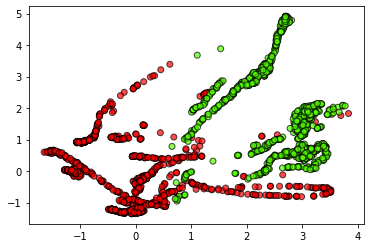

In [59]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9934751983391414
F1-score [0.99659601 0.92156863]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     12968
           1       0.86      1.00      0.92       519

    accuracy                           0.99     13487
   macro avg       0.93      0.99      0.96     13487
weighted avg       0.99      0.99      0.99     13487



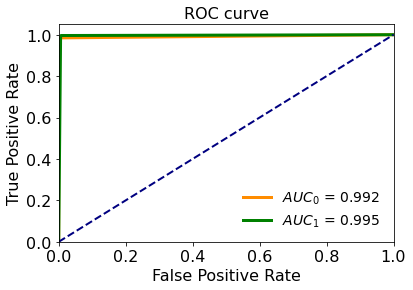

In [60]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

#### CondensedNearestNeighbour

In [61]:
from imblearn.under_sampling import CondensedNearestNeighbour

cnn = CondensedNearestNeighbour(random_state=42, sampling_strategy="majority")
X_res, y_res = cnn.fit_resample(X_train, y_train)

print('Partitioned and CNN Undersampled dataset %s' % Counter(pd.Series(y_res)))
print('Share of Occupieds %s\n' % round(y_res.mean(),2))

Partitioned and CNN Undersampled dataset Counter({1: 1210, 0: 71})
Share of Occupieds 0.94



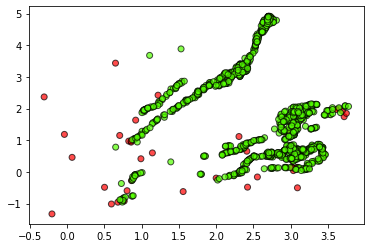

In [62]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.8692815303625714
F1-score [0.9271096  0.36742017]
              precision    recall  f1-score   support

           0       1.00      0.86      0.93     12968
           1       0.23      0.99      0.37       519

    accuracy                           0.87     13487
   macro avg       0.61      0.93      0.65     13487
weighted avg       0.97      0.87      0.91     13487



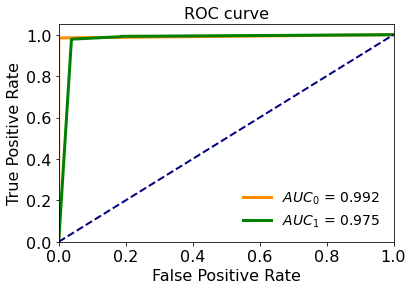

In [63]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Oversampling

#### RandomOverSampler

In [64]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Partitioned and ROS Oversampled dataset %s' % Counter(pd.Series(y_res)))
print('Share of Occupieds %s\n' % round(y_res.mean(),2))

Partitioned and ROS Oversampled dataset Counter({0: 30257, 1: 30257})
Share of Occupieds 0.5



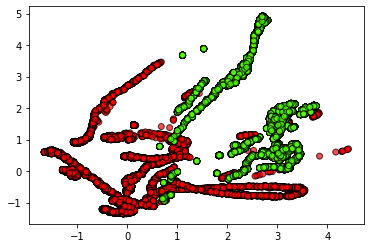

In [65]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9985170905316231
F1-score [0.99922875 0.98080614]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12968
           1       0.98      0.98      0.98       519

    accuracy                           1.00     13487
   macro avg       0.99      0.99      0.99     13487
weighted avg       1.00      1.00      1.00     13487



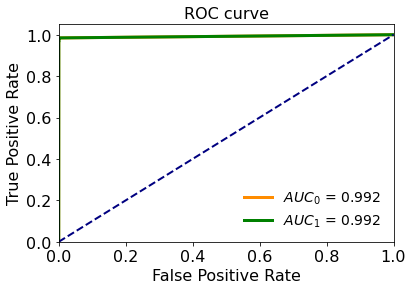

In [66]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

#### SMOTE

In [67]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Partitioned and SMOTEd dataset %s' % Counter(pd.Series(y_res)))
print('Share of Occupieds %s\n' % round(y_res.mean(),2))

Partitioned and SMOTEd dataset Counter({0: 30257, 1: 30257})
Share of Occupieds 0.5



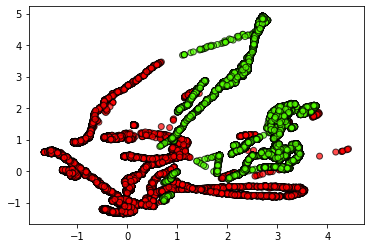

In [68]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9982946541113665
F1-score [0.99911303 0.97794823]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12968
           1       0.97      0.98      0.98       519

    accuracy                           1.00     13487
   macro avg       0.99      0.99      0.99     13487
weighted avg       1.00      1.00      1.00     13487



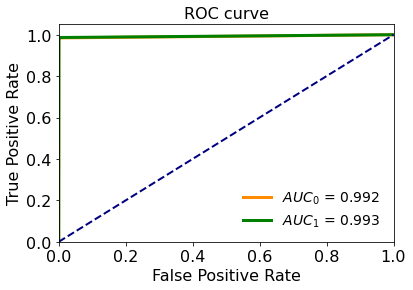

In [69]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

#### Class Weight

Accuracy 0.9977756357974346
F1-score [0.99884313 0.97120921]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12968
           1       0.97      0.97      0.97       519

    accuracy                           1.00     13487
   macro avg       0.98      0.99      0.99     13487
weighted avg       1.00      1.00      1.00     13487



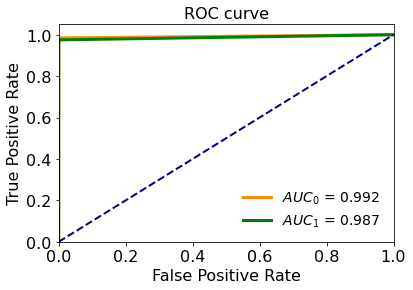

In [71]:
clf = DecisionTreeClassifier(min_samples_leaf=3, class_weight={0:1, 1: 24}, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()